In [8]:
import os
import re
import math
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import networkx as nx

from wordcloud import WordCloud
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import spacy
nlp = spacy.load('en_core_web_sm')
nlp.remove_pipe('parser')
nlp.remove_pipe('ner')
#nlp.remove_pipe('tagger')

import gensim
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [9]:
input_dir = 'data'
#print(os.listdir(input_dir))

professionals = pd.read_csv(os.path.join(input_dir, 'professionals.csv'))
groups = pd.read_csv(os.path.join(input_dir, 'groups.csv'))
comments = pd.read_csv(os.path.join(input_dir, 'comments.csv'))
school_memberships = pd.read_csv(os.path.join(input_dir, 'school_memberships.csv'))
tags = pd.read_csv(os.path.join(input_dir, 'tags.csv'))
emails = pd.read_csv(os.path.join(input_dir, 'emails.csv'))
group_memberships = pd.read_csv(os.path.join(input_dir, 'group_memberships.csv'))
answers = pd.read_csv(os.path.join(input_dir, 'answers.csv'))
students = pd.read_csv(os.path.join(input_dir, 'students.csv'))
matches = pd.read_csv(os.path.join(input_dir, 'matches.csv'))
questions = pd.read_csv(os.path.join(input_dir, 'questions.csv'))
tag_users = pd.read_csv(os.path.join(input_dir, 'tag_users.csv'))
tag_questions = pd.read_csv(os.path.join(input_dir, 'tag_questions.csv'))
answer_scores = pd.read_csv(os.path.join(input_dir, 'answer_scores.csv'))
question_scores = pd.read_csv(os.path.join(input_dir, 'question_scores.csv'))

In [10]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)

seed = 13
random.seed(seed)
np.random.seed(seed)

In [17]:
print(f"""professionals - {professionals.columns} \n
students - {students.columns} \n\n questions - {questions.columns} \n
answers - {answers.columns}
""")

professionals - Index(['professionals_id', 'professionals_location', 'professionals_industry',
       'professionals_headline', 'professionals_date_joined'],
      dtype='object') 

students - Index(['students_id', 'students_location', 'students_date_joined'], dtype='object') 

 questions - Index(['questions_id', 'questions_author_id', 'questions_date_added',
       'questions_title', 'questions_body'],
      dtype='object') 

answers - Index(['answers_id', 'answers_author_id', 'answers_question_id',
       'answers_date_added', 'answers_body'],
      dtype='object')



In [26]:
question_scores.columns, answer_scores.columns, tag_questions.columns

(Index(['id', 'score'], dtype='object'),
 Index(['id', 'score'], dtype='object'),
 Index(['tag_questions_tag_id', 'tag_questions_question_id'], dtype='object'))

### Features extraction

#### tokenize POS

In [12]:
# Spacy Tokenfilter for part-of-speech tagging
token_pos = ['NOUN', 'VERB', 'PROPN', 'ADJ', 'INTJ', 'X']

# The data export was from 1. February 2019. For Production use datetime.now()
actual_date = datetime(2019, 2 ,1)

In [13]:
def nlp_preprocessing(data):
    """ Use NLP to transform the text corpus to cleaned sentences and word tokens

        param data: List with sentences, which should be processed.
        return processed_tokens: List with the cleaned and tokenized sentences
    """    
    def token_filter(token):
        """ Keep tokens who are alphapetic, in the pos (part-of-speech) list and not in stop list
            
        """    
        return not token.is_stop and token.is_alpha and token.pos_ in token_pos
    
    data = [re.compile(r'<[^>]+>').sub('', x) for x in data] #Remove HTML-tags
    processed_tokens = []
    data_pipe = nlp.pipe(data)
    for doc in data_pipe:
        filtered_tokens = [token.lemma_.lower() for token in doc if token_filter(token)]
        processed_tokens.append(filtered_tokens)
    return processed_tokens

### Features
First we transform the datetime columns (`date_added` and `date_joined`), so that we can work with time delta functions.  
After this we create the following new columns:  

**DataFrame Questions:**  
* **questions_full_text:** Merge the questions title with the body for later use of NLP.  
* **questions_answers_count:** How many answers a question has.  
* **questions_first_answers:** The timestamp for the first answer of the question.  
* **questions_last_answers:** The timestamp for the last answer of the question.  
* **questions_hearts:** Hearts score for the question.  
* **questions_tags:** List with tags for the question.  
* **nlp_tokens:** Extract relevant tokens from the question full text.  

**DataFrame Answers:**  
* **time_delta_answert:** Time delta from question to answer.  
* **answers_time_rank:** Ranking for time to answer the question.  
* **answers_hearts:** Hearts score for the answer.

**DataFrame Professionals:**  
* **professionals_time_delta_joined:** Time since creating the account.  
* **professionals_answers_count:** Number of written answers.  
* **professionals_comments_count:** Number of written comments.  
* **date_last_answer:** Date last answer.  
* **date_first_answer:** Date first answer.  
* **date_last_comment:** Date last comment.  
* **date_first_comment:** Date first comment.  
* **date_last_activity:** Date last activity (answer or comment).  
* **date_first_activity:** Date first activity (answer or comment).  
* **professional_answers_hearts:** Hearts score for all answers. 
* **professional_tags:** List with tags for the professional.  

**DataFrame Students:**  
* **students_time_delta_joined:** Time since creating the account.  
* **students_questions_count:** Number of written questions.  
* **students_comments_count:** Number of written comments.  
* **date_last_questions:** Date last question.  
* **date_first_questions:** Date first question.  
* **date_last_comment:** Date last comment.  
* **date_first_comment:** Date first comment.  
* **date_last_activity:** Date last activity (question or comment).  
* **date_first_activity:** Date first activity (question or comment).  
* **students_questions_hearts:** Hearts score for all questions.  
* **students_tags:** List with tags for the students.  

**New DataFrame emails_response:**  
Has the response activity from professionals to emails and additional informations about the questions behind.
* **time_delta_email_answer:** Time needed the question was answered after the email was send.  
* **time_delta_question_email:** Time needed the email was send after the questions was written.

In [18]:
# Transform datetime datatypes
questions['questions_date_added'] = pd.to_datetime(questions['questions_date_added'], infer_datetime_format=True)
answers['answers_date_added'] = pd.to_datetime(answers['answers_date_added'], infer_datetime_format=True)
professionals['professionals_date_joined'] = pd.to_datetime(professionals['professionals_date_joined'], infer_datetime_format=True)
students['students_date_joined'] = pd.to_datetime(students['students_date_joined'], infer_datetime_format=True)
emails['emails_date_sent'] = pd.to_datetime(emails['emails_date_sent'], infer_datetime_format=True)
comments['comments_date_added'] = pd.to_datetime(comments['comments_date_added'], infer_datetime_format=True)


### Questions

In [19]:
# Merge Question Title and Body
questions['questions_full_text'] = questions['questions_title'] +'\r\n\r\n'+ questions['questions_body']

In [20]:
# Count of answers for a question
temp = answers.groupby('answers_question_id').size()
questions['questions_answers_count'] = pd.merge(questions, pd.DataFrame(temp.rename('count')), left_on='questions_id', right_index=True, how='left')['count'].fillna(0).astype(int)

In [21]:
# First answer for questions
temp = answers[['answers_question_id', 'answers_date_added']].groupby('answers_question_id').min()
questions['questions_first_answers'] = pd.merge(questions, pd.DataFrame(temp), left_on='questions_id', right_index=True, how='left')['answers_date_added']

In [22]:
# Last answer for questions
temp = answers[['answers_question_id', 'answers_date_added']].groupby('answers_question_id').max()
questions['questions_last_answers'] = pd.merge(questions, pd.DataFrame(temp), left_on='questions_id', right_index=True, how='left')['answers_date_added']

In [23]:
# Hearts Score
temp = pd.merge(questions, question_scores, left_on='questions_id', right_on='id', how='left')
questions['questions_hearts'] = temp['score'].fillna(0).astype(int)

In [30]:
questions.columns,tags.columns, tag_questions.columns , questions.shape,tags.shape, tag_questions.shape, tags.head(),tag_questions.head()

(Index(['questions_id', 'questions_author_id', 'questions_date_added',
        'questions_title', 'questions_body', 'questions_full_text',
        'questions_answers_count', 'questions_first_answers',
        'questions_last_answers', 'questions_hearts'],
       dtype='object'),
 Index(['tags_tag_id', 'tags_tag_name'], dtype='object'),
 Index(['tag_questions_tag_id', 'tag_questions_question_id'], dtype='object'),
 (23931, 10),
 (16269, 2),
 (76553, 2),
    tags_tag_id      tags_tag_name
 0  27490        college          
 1  461          computer-science 
 2  593          computer-software
 3  27292        business         
 4  18217        doctor           ,
    tag_questions_tag_id         tag_questions_question_id
 0  28930                 cb43ebee01364c68ac61d347a393ae39
 1  28930                 47f55e85ce944242a5a347ab85a8ffb4
 2  28930                 ccc30a033a0f4dfdb2eb987012f25792
 3  28930                 e30b274e48d741f7bf50eb5e7171a3c0
 4  28930                 3d22742052d

In [31]:
tags.tags_tag_id.nunique(), tag_questions.tag_questions_tag_id.nunique()

(16269, 7091)

In [32]:
set(tag_questions.tag_questions_tag_id)-set(tags.tags_tag_id)

set()

In [33]:
# Find list of tags for a question
temp = pd.merge(questions, tag_questions, left_on='questions_id', right_on='tag_questions_question_id', how='inner')
temp = pd.merge(temp, tags, left_on='tag_questions_tag_id', right_on='tags_tag_id', how='inner')
temp = temp.groupby('questions_id')['tags_tag_name'].apply(list).rename('questions_tags')
questions['questions_tags'] = pd.merge(questions, temp.to_frame(), left_on='questions_id', right_index=True, how='left')['questions_tags']

In [34]:
# Get NLP Tokens
questions['nlp_tokens'] = nlp_preprocessing(questions['questions_full_text'])

### Answers

**DataFrame Answers:**  
* **time_delta_answert:** Time delta from question to answer.  
* **answers_time_rank:** Ranking for time to answer the question.  
* **answers_hearts:** Hearts score for the answer.

In [35]:
# Days required to answer the question
temp = pd.merge(questions, answers, left_on='questions_id', right_on='answers_question_id')
answers['time_delta_answer'] = (temp['answers_date_added'] - temp['questions_date_added'])

In [36]:
# Ranking for answers time
answers['answers_time_rank'] = answers.groupby('answers_question_id')['time_delta_answer'].rank(method='min').astype(int)

In [37]:
# Hearts Score
temp = pd.merge(answers, answer_scores, left_on='answers_id', right_on='id', how='left')
answers['answers_hearts'] = temp['score'].fillna(0).astype(int)

In [38]:
answers.head()

,answers_id,answers_author_id,answers_question_id,answers_date_added,answers_body,time_delta_answer,answers_time_rank,answers_hearts
0,4e5f01128cae4f6d8fd697cec5dca60c,36ff3b3666df400f956f8335cf53e09e,332a511f1569444485cf7a7a556a5e54,2016-04-29 19:40:14,<p>Hi!</p>\n<p>You are asking a very interesting question. I am giving you two sites that will give you some of an explanation that may answer your question.</p>\n<p>http://mathforum.org/dr.math/faq/faq.why.math.html</p>\n<p>http://www.mathworksheetscenter.com/mathtips/mathissoimportant.html</p>\n<p>Let me know if this helps</p>,3 days 08:25:48,1,0
1,ada720538c014e9b8a6dceed09385ee3,2aa47af241bf42a4b874c453f0381bd4,eb80205482e4424cad8f16bc25aa2d9c,2018-05-01 14:19:08,"<p>Hi. I joined the Army after I attended college and received a Bachelor's Degree in Criminal Justice. Commissioned officers enter the Military with a four year degree or receive officer training after joining and complete a tour. You can prepare yourself by taking Reserve Officer Training Corps (ROTC) while in high school or a university. You can also attend Officer Candidate School (OCS) after graduating from college or become commissioned by earning a professional degree. If you decide to earn a degree, think about what you would like to do while in the military. The experience in the military was very rewarding. I wish you well and much success in your future. </p>",710 days 21:30:43,1,0
2,eaa66ef919bc408ab5296237440e323f,cbd8f30613a849bf918aed5c010340be,eb80205482e4424cad8f16bc25aa2d9c,2018-05-02 02:41:02,"<p>Dear Priyanka,</p><p>Greetings! I have answered this question to Eshwari few days ago. I am going to reproduce that answer with bit of modifications as required for better clarity. </p><p><br></p><p>From your background, I could make out that you are from Bangalore and a student of 10th standard but your location is Rhode Island, USA. So I am not very clear as to which Army you wish to join ? Is it the US Army or the Indian Army? It is important to know that very few foreign nationals can join Indian Army (like Nepali citizens etc.). So you have to ascertain for yourself as to which citizenship you hold and accordingly you can join armed forces of the respective countries. Both are highly professional armies and respected a lot. I shall answer the modalities about the Indian Army, assuming that is the natural choice.</p><p><br></p><p>So, to answer your query, there are following options for you to become army officer:</p><ol><li> Do your B.Sc and that will be good as you have wider choices including flying branches in air force and executive branches in Navy. Similarly BA/B.Com if you are not looking for flying or executive branches. </li><li> Should you wish to be doctor in Army then you can appear for entrance Test for AFMC, Pune or Army Dental College after class 12th with PCMB. However, you can do the same by attending Medical colleges from civil institutes in India/abroad. </li><li> You can also join Military Nursing Services after B.Sc or Diploma in Nursing but majority of them are trained within army organisations (after 12th only with PCMB). </li><li> You can join after doing your graduation in Engineering (Civil, Mech, Electrical, Electronics or Computer Sciences) or Masters in Physics with Electronics or Computers for engineering branches.</li><li>You can also join in Education Corps by doing M.Sc/MA/M.Com with or without B.Ed or in Legal services by doing your Law Degree. </li></ol><p><br></p><p>After your basic education, application and selection test processes, one has to clear SSB (Services Selection Board) which is a very stringent 5 days test (compulsory for all including Women officers except medical professionals). It is one of the best methods of test I know to assess the suitability for military services (as officers), a proven method of testing of one's psyche, leadership qualities which takes all the aspects of your personality into account and decide. Although, success rate is pr

### Professionals
**DataFrame Professionals:**  
* **professionals_time_delta_joined:** Time since creating the account.  
* **professionals_answers_count:** Number of written answers.  
* **professionals_comments_count:** Number of written comments.  
* **date_last_answer:** Date last answer.  
* **date_first_answer:** Date first answer.  
* **date_last_comment:** Date last comment.  
* **date_first_comment:** Date first comment.  
* **date_last_activity:** Date last activity (answer or comment).  
* **date_first_activity:** Date first activity (answer or comment).  
* **professional_answers_hearts:** Hearts score for all answers. 
* **professional_tags:** List with tags for the professional.  

In [39]:
# Time since joining
professionals['professionals_time_delta_joined'] = actual_date - professionals['professionals_date_joined']

In [40]:
# Number of answers
temp = answers.groupby('answers_author_id').size()
professionals['professionals_answers_count'] = pd.merge(professionals, pd.DataFrame(temp.rename('count')), left_on='professionals_id', right_index=True, how='left')['count'].fillna(0).astype(int)

In [41]:
# Number of comments
temp = comments.groupby('comments_author_id').size()
professionals['professionals_comments_count'] = pd.merge(professionals, pd.DataFrame(temp.rename('count')), left_on='professionals_id', right_index=True, how='left')['count'].fillna(0).astype(int)

In [42]:
# Last activity (Answer)
temp = answers.groupby('answers_author_id')['answers_date_added'].max()
professionals['date_last_answer'] = pd.merge(professionals, pd.DataFrame(temp.rename('last_answer')), left_on='professionals_id', right_index=True, how='left')['last_answer']

In [43]:
# First activity (Answer)
temp = answers.groupby('answers_author_id')['answers_date_added'].min()
professionals['date_first_answer'] = pd.merge(professionals, pd.DataFrame(temp.rename('first_answer')), left_on='professionals_id', right_index=True, how='left')['first_answer']

In [44]:
# Last activity (Comment)
temp = comments.groupby('comments_author_id')['comments_date_added'].max()
professionals['date_last_comment'] = pd.merge(professionals, pd.DataFrame(temp.rename('last_comment')), left_on='professionals_id', right_index=True, how='left')['last_comment']

In [45]:
# First activity (Comment)
temp = comments.groupby('comments_author_id')['comments_date_added'].min()
professionals['date_first_comment'] = pd.merge(professionals, pd.DataFrame(temp.rename('first_comment')), left_on='professionals_id', right_index=True, how='left')['first_comment']

In [46]:
# Last activity (Total)
professionals['date_last_activity'] = professionals[['date_last_answer', 'date_last_comment']].max(axis=1)

In [47]:
# First activity (Total)
professionals['date_first_activity'] = professionals[['date_first_answer', 'date_first_comment']].min(axis=1)

In [48]:
# Total Hearts score
temp = answers.groupby('answers_author_id')['answers_hearts'].sum()
professionals['professional_answers_hearts'] = pd.merge(professionals, pd.DataFrame(temp.rename('answers_hearts')), left_on='professionals_id', right_index=True, how='left')['answers_hearts'].fillna(0).astype(int)

In [49]:
# Professionals Tags to List
temp = pd.merge(professionals, tag_users, left_on='professionals_id', right_on='tag_users_user_id', how='inner')
temp = pd.merge(temp, tags, left_on='tag_users_tag_id', right_on='tags_tag_id', how='inner')
temp = temp.groupby('professionals_id')['tags_tag_name'].apply(list).rename('professionals_tags')
professionals['professionals_tags'] = pd.merge(professionals, temp.to_frame(), left_on='professionals_id', right_index=True, how='left')['professionals_tags']

In [50]:
### Students

In [51]:
# Time since joining
students['students_time_delta_joined'] = actual_date - students['students_date_joined']

In [52]:
# Number of answers
temp = questions.groupby('questions_author_id').size()
students['students_questions_count'] = pd.merge(students, pd.DataFrame(temp.rename('count')), left_on='students_id', right_index=True, how='left')['count'].fillna(0).astype(int)

In [53]:
# Number of comments
temp = comments.groupby('comments_author_id').size()
students['students_comments_count'] = pd.merge(students, pd.DataFrame(temp.rename('count')), left_on='students_id', right_index=True, how='left')['count'].fillna(0).astype(int)

In [54]:
# Last activity (Question)
temp = questions.groupby('questions_author_id')['questions_date_added'].max()
students['date_last_question'] = pd.merge(students, pd.DataFrame(temp.rename('last_question')), left_on='students_id', right_index=True, how='left')['last_question']

In [55]:
# First activity (Question)
temp = questions.groupby('questions_author_id')['questions_date_added'].min()
students['date_first_question'] = pd.merge(students, pd.DataFrame(temp.rename('first_question')), left_on='students_id', right_index=True, how='left')['first_question']

In [56]:
# Last activity (Comment)
temp = comments.groupby('comments_author_id')['comments_date_added'].max()
students['date_last_comment'] = pd.merge(students, pd.DataFrame(temp.rename('last_comment')), left_on='students_id', right_index=True, how='left')['last_comment']

In [57]:
# First activity (Comment)
temp = comments.groupby('comments_author_id')['comments_date_added'].min()
students['date_first_comment'] = pd.merge(students, pd.DataFrame(temp.rename('first_comment')), left_on='students_id', right_index=True, how='left')['first_comment']

In [58]:
# Last activity (Total)
students['date_last_activity'] = students[['date_last_question', 'date_last_comment']].max(axis=1)

In [59]:
# First activity (Total)
students['date_first_activity'] = students[['date_first_question', 'date_first_comment']].min(axis=1)

In [60]:
# Total Hearts score
temp = questions.groupby('questions_author_id')['questions_hearts'].sum()
students['students_questions_hearts'] = pd.merge(students, pd.DataFrame(temp.rename('questions_hearts')), left_on='students_id', right_index=True, how='left')['questions_hearts'].fillna(0).astype(int)

In [61]:
# Students Tags to List
temp = pd.merge(students, tag_users, left_on='students_id', right_on='tag_users_user_id', how='inner')
temp = pd.merge(temp, tags, left_on='tag_users_tag_id', right_on='tags_tag_id', how='inner')
temp = temp.groupby('students_id')['tags_tag_name'].apply(list).rename('students_tags')
students['students_tags'] = pd.merge(students, temp.to_frame(), left_on='students_id', right_index=True, how='left')['students_tags']

In [62]:
### Emails Response
emails_response = pd.merge(emails, matches, left_on='emails_id', right_on='matches_email_id', how='inner')
emails_response = pd.merge(emails_response, questions, left_on='matches_question_id', right_on='questions_id', how='inner')
emails_response = pd.merge(emails_response, answers, left_on=['emails_recipient_id', 'matches_question_id'], right_on=['answers_author_id', 'answers_question_id'], how='left')
emails_response = emails_response.drop(['matches_email_id', 'matches_question_id', 'answers_id', 'answers_author_id', 'answers_body', 'answers_question_id'], axis=1)
emails_response = emails_response.drop(['questions_author_id', 'questions_title', 'questions_body', 'questions_full_text'], axis=1)
emails_response['time_delta_email_answer'] = (emails_response['answers_date_added'] - emails_response['emails_date_sent'])
emails_response['time_delta_question_email'] = (emails_response['emails_date_sent'] - emails_response['questions_date_added'])

### EDA

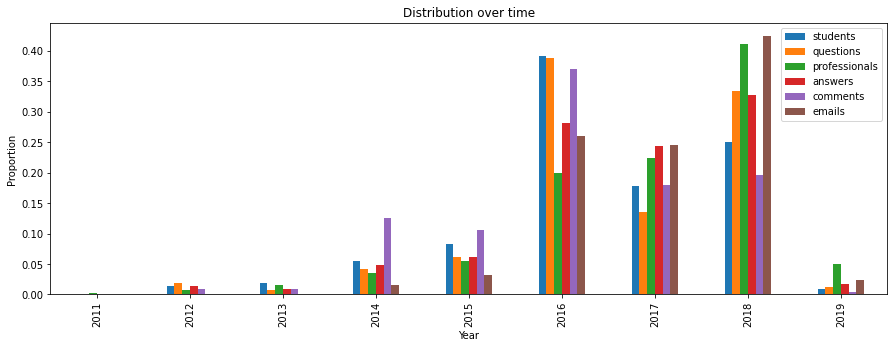

In [63]:
plt_professionals = (professionals.groupby([professionals['professionals_date_joined'].dt.year]).size()/len(professionals.index))
plt_students = (students.groupby([students['students_date_joined'].dt.year]).size()/len(students.index))
plt_questions = (questions.groupby([questions['questions_date_added'].dt.year]).size()/len(questions.index))
plt_answers = (answers.groupby([answers['answers_date_added'].dt.year]).size()/len(answers.index))
plt_emails = (emails.groupby([emails['emails_date_sent'].dt.year]).size()/len(emails.index))
plt_comments = (comments.groupby([comments['comments_date_added'].dt.year]).size()/len(comments.index))
plt_data = pd.DataFrame({'students':plt_students,
                         'questions': plt_questions,
                         'professionals':plt_professionals,
                        'answers':plt_answers,
                        'comments':plt_comments,
                        'emails':plt_emails})
plt_data.plot(kind='bar', figsize=(15, 5))
plt.xlabel('Year')
plt.ylabel('Proportion')
plt.title('Distribution over time')
plt.show()

In [ ]:
If we see after 2016 only data 